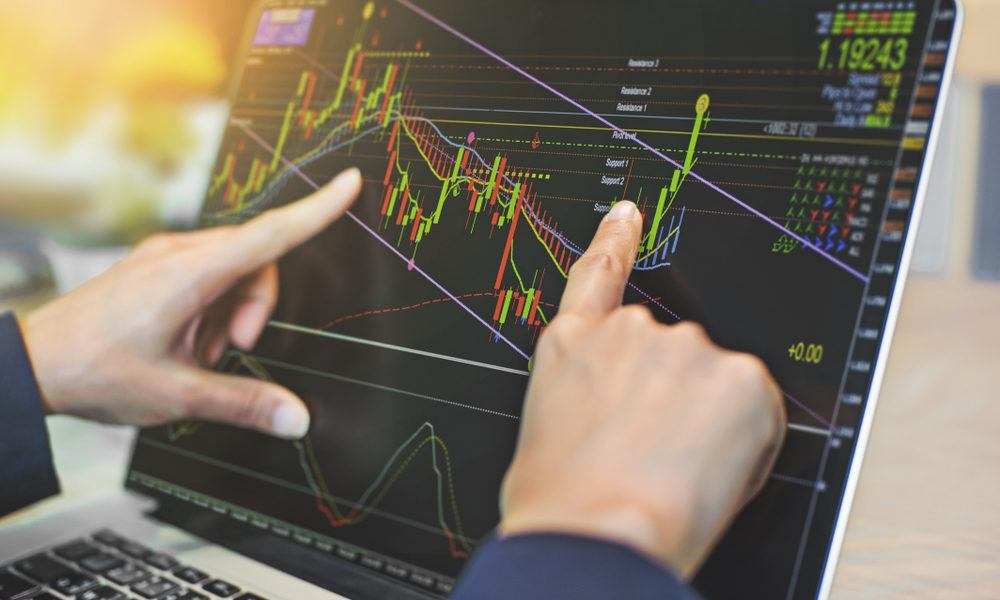

# Введение

Наша цель - построить математическую модель предсказания колебания биржевого курса для дальнейшего использования в качестве сигнала для сверх-краткосрочной (пипсовой) биржевой торговли.
Конечная цель - написание коммерчески-успешного торгового автомата.

Для этого я выбрал валютную пару EUR-USD на рынке Форекс. В качестве площадки был выбран Альфа-Банк.

Конечно, написание коммерчески-успешного торгового автомата скорее всего не выполнима в рамках этой дипломной работы. Краткосрочная торговля - одна из самых сложных для предсказания видов биржевой торговли. Слишком много факторов влиет, которые в принципе не могут быть считаны моделью. Однако подобная работа поможет мне лучше разобраться и с работами моделей, и с тонкостями работы биржевых автоматов.

Но цель - именно такая, и к ней будем стремится приблизиться как можно ближе.

А самое главное - тестируя модель в продакте, что-бы увидеть результаты - не надо неделями и месяцами ждать, что-бы собрать достаточную статистику. Достаточно пары часов, а то и нескольких минут для получения результата.

Для торговой стратегии я выбрал максимальную длину торгового ордера в 10 минут. Через 10 минут ордер принудительно закрывается, если до этого не закрылся по stop-loss или take-profit.
Торговля будет веститсь на демо-счете с хэджированием от Альфа-Банка.

## 0. Первичная инициализация

Импорт библиотек, задание переменных, констант.

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

import MetaTrader5 as mt5 # для работы с торговой платформой

import threading # для многопоточности
import pickle # сохранение объектов

from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn.metrics import make_scorer #создание метрики
from sklearn import model_selection #методы разделения и валидации

from prophet import Prophet
#from neuralprophet import NeuralProphet

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import optuna # для оптимизации гиперпараметров
import pmdarima as pm # для автоматического подбора гиперпараметров

from statsmodels.tsa.arima.model import ARIMA # для модели ARIMA

import datetime as dt
from datetime import datetime

from tqdm import tqdm  # для отображения прогресса долгих рассчетов
tqdm.pandas()

from IPython.display import clear_output # для очистки вывода
import logging # для логирования
import random # для генерации случайных чисел
import winsound  # пищим динамиком, когда надо
import time

pd.options.mode.chained_assignment = None  # для подавления предупреждений

In [2]:
# зададим переменные
random_state = 42
symbol = "EURUSDrfd"
time_delta = 10 * 60 # 10 минут - время, которое нас интересует в качестве предсказания для пипсовой торговли
pips_delta = 0.00025 # 25 пипсов - минимальное изменение цены, которое нас интересует в качестве предсказания для пипсовой торговли (это мы вычислим позже)

In [3]:
# функция, что-бы попищать динамиком. Полезно, что-бы просигналить, что долгий рассчёт окончен

def beep():
    frequency = 2500  # Set Frequency To 2500 Hertz
    duration = 500  # Set Duration To 1000 ms == 1 second
    winsound.Beep(frequency, duration)
    winsound.Beep(round(frequency/2), duration)
    winsound.Beep(round(frequency/4), duration)
    winsound.Beep(round(frequency/2), duration)
    winsound.Beep(frequency, duration)

# 1. Сбор данных

### Получение датасета

Поскольку результаты, полученные моделью предполагается использовать в работе торгового терминала, логично, что датасет для работы лучше всего получить с этого-же терминала.

Терминал (Metatrader 5) уже должен быть установлен на машине, настроен и подключен к торговому счёту. Так-же, для дальнейшей работы продакта - должен быть разрешен алготрейдинг.

Демо-счёт MT5 (с хеджированием)<br>
Логин:<br>
2000061156<br>
Пароль трейдера:<br>
{_______________}  # пароль удалён, конечно

In [4]:
# выведем данные о пакете MetaTrader5
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.45


In [5]:
# установим подключение к терминалу MetaTrader 5 на указанный торговый счет
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

In [6]:
# получим данные о нашем выбранном инструменте

symbol_info = mt5.symbol_info(symbol)

symbol_info

SymbolInfo(custom=False, chart_mode=0, select=True, visible=True, session_deals=0, session_buy_orders=0, session_sell_orders=0, volume=0, volumehigh=0, volumelow=0, time=1701693877, digits=5, spread=14, spread_float=True, ticks_bookdepth=0, trade_calc_mode=0, trade_mode=4, start_time=0, expiration_time=0, trade_stops_level=7, trade_freeze_level=0, trade_exemode=2, swap_mode=1, swap_rollover3days=3, margin_hedged_use_leg=False, expiration_mode=11, filling_mode=1, order_mode=55, order_gtc_mode=0, option_mode=0, option_right=0, bid=1.08764, bidhigh=1.08943, bidlow=1.08491, ask=1.08778, askhigh=1.08957, asklow=1.08505, last=0.0, lasthigh=0.0, lastlow=0.0, volume_real=0.0, volumehigh_real=0.0, volumelow_real=0.0, option_strike=0.0, point=1e-05, trade_tick_value=1.0, trade_tick_value_profit=1.0, trade_tick_value_loss=1.0, trade_tick_size=1e-05, trade_contract_size=100000.0, trade_accrued_interest=0.0, trade_face_value=0.0, trade_liquidity_rate=0.0, volume_min=0.01, volume_max=100.0, volume_s

Пока неизвестно, сколько нам потребуется данных для работы модели. Может, хватит данных за одну неделю. А, возможно, потребуется информация за несколько лет. Для начала используем данные за один месяц. В дальнейшем - проведем иследование, сколько данных оптимально нужно для обучения модели.

In [7]:
# получим все тики по выбранному инструменту за октябрь 2023 года

# создадим структуру DataFrame для хранения тиков
ticks_frame = pd.DataFrame(columns=['time', 'bid', 'ask', 'last', 'volume'])

# получим тиковые данные за 2020.10.01
#ticks = mt5.copy_ticks_from(symbol, datetime(2020,10,1,0,0,0,0), 100000, mt5.COPY_TICKS_ALL)
ticks = mt5.copy_ticks_range(symbol, datetime(2023,10,1,0,0,0,0), datetime(2023,10,31,0,0,0,0), mt5.COPY_TICKS_ALL)

# заполним DataFrame
ticks_frame = pd.DataFrame(ticks)

# выведем данные
ticks_frame

,time,bid,ask,last,volume,time_msc,flags,volume_real
0,1696212000,1.05589,1.05604,0.0,0,1696212000222,230,0.0
1,1696212000,1.05590,1.05604,0.0,0,1696212000494,226,0.0
2,1696212000,1.05589,1.05604,0.0,0,1696212000688,226,0.0
3,1696212000,1.05590,1.05604,0.0,0,1696212000725,226,0.0
4,1696212000,1.05590,1.05604,0.0,0,1696212000947,96,0.0
...,...,...,...,...,...,...,...,...
2574616,1698699591,1.06107,1.06121,0.0,0,1698699591590,230,0.0
2574617,1698699591,1.06108,1.06122,0.0,0,1698699591703,230,0.0
2574618,1698699592,1.06107,1.06121,0.0,0,1698699592087,230,0.0
2574619,1698699598,1.06106,1.06120,0.0,0,1698699598075,230,0.0


# 2. Подготовка данных

## 2.1 Очистка

In [8]:
# Выведем информацию о DataFrame
ticks_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2574621 entries, 0 to 2574620
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   time         int64  
 1   bid          float64
 2   ask          float64
 3   last         float64
 4   volume       uint64 
 5   time_msc     int64  
 6   flags        uint32 
 7   volume_real  float64
dtypes: float64(4), int64(2), uint32(1), uint64(1)
memory usage: 147.3 MB


In [9]:
# выведем статистику по тиковым данным
ticks_frame.describe()

,time,bid,ask,last,volume,time_msc,flags,volume_real
count,2.574621e+06,2.574621e+06,2.574621e+06,2574621.0,2574621.0,2.574621e+06,2.574621e+06,2574621.0
mean,1.697351e+09,1.055751e+00,1.055893e+00,0.0,0.0,1.697351e+12,2.177882e+02,0.0
std,7.186076e+05,4.358614e-03,4.358339e-03,0.0,0.0,7.186076e+08,3.866391e+01,0.0
min,1.696212e+09,1.044760e+00,1.044900e+00,0.0,0.0,1.696212e+12,4.000000e+00,0.0
25%,1.696620e+09,1.053120e+00,1.053260e+00,0.0,0.0,1.696620e+12,2.300000e+02,0.0
50%,1.697226e+09,1.055790e+00,1.055940e+00,0.0,0.0,1.697226e+12,2.300000e+02,0.0
75%,1.698056e+09,1.058800e+00,1.058940e+00,0.0,0.0,1.698056e+12,2.300000e+02,0.0
max,1.698700e+09,1.069370e+00,1.069510e+00,0.0,0.0,1.698700e+12,2.300000e+02,0.0


Как видим - поля last, volume и volume_real - пустые. Их можно удалить.Так-же можно удалить поле time_msk и flags - они нам не пригодятся

In [10]:
# Удалим поля, которые нам не нужны

ticks_frame.drop(['last','volume', 'volume_real', 'time_msc', 'flags'], axis=1, inplace=True)

# для сокращения объема данных преобразуем поля bid и ask в тип float32
ticks_frame['bid'] = ticks_frame['bid'].astype('float32')
ticks_frame['ask'] = ticks_frame['ask'].astype('float32')

# преобразуем поле time в тип datetime
ticks_frame['time'] = pd.to_datetime(ticks_frame['time'], unit='s')

ticks_frame.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2574621 entries, 0 to 2574620
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   time    datetime64[ns]
 1   bid     float32       
 2   ask     float32       
dtypes: datetime64[ns](1), float32(2)
memory usage: 39.3 MB


Отлично! Датасет уменьшился втрое.

In [11]:
ticks_frame

,time,bid,ask
0,2023-10-02 02:00:00,1.05589,1.05604
1,2023-10-02 02:00:00,1.05590,1.05604
2,2023-10-02 02:00:00,1.05589,1.05604
3,2023-10-02 02:00:00,1.05590,1.05604
4,2023-10-02 02:00:00,1.05590,1.05604
...,...,...,...
2574616,2023-10-30 20:59:51,1.06107,1.06121
2574617,2023-10-30 20:59:51,1.06108,1.06122
2574618,2023-10-30 20:59:52,1.06107,1.06121
2574619,2023-10-30 20:59:58,1.06106,1.06120


На данный момент у нас есть много тиков, в одной и той-же секунде. А так-же есть секунды, в которых тиков нет вообще. Это, например, выходные или праздничные дни, перерывы в работе биржи. Просто отсутвующие ордера в конкретную секунду, так может быть.

In [12]:
# проведем ресемплирование тиковых данных в среднее значение с периодом 1 секунда
# колебания цены в течении секунды не так важны
# так-же добавим в ресемплированные данные колонку с количеством тиков в секунду, возможно, это ценная информация:
# если в секунду было много тиков, то это может говорить о том, что в этот момент было много сделок, и это может быть важной информацией

ticks_frame = ticks_frame.resample('1S', on='time').agg({'bid':'mean', 'ask':'mean', 'time':'count'})

# недостающие значения заполним интерполяцией
# ticks_frame = ticks_frame.interpolate(method='time')

# недостающие значения заполним предыдущими значениями,
ticks_frame = ticks_frame.fillna(method='ffill')

# выведем данные
ticks_frame

,bid,ask,time
time,,,
2023-10-02 02:00:00,1.055896,1.056040,5
2023-10-02 02:00:01,1.055873,1.056018,12
2023-10-02 02:00:02,1.055845,1.055990,4
2023-10-02 02:00:03,1.055855,1.056000,6
2023-10-02 02:00:04,1.055894,1.056042,5
...,...,...,...
2023-10-30 20:59:54,1.061070,1.061210,0
2023-10-30 20:59:55,1.061070,1.061210,0
2023-10-30 20:59:56,1.061070,1.061210,0


Отлично. Мы получили непрерывный последовательный временной ряд.

<Axes: title={'center': 'Средняя цена Bid за секунду (октябрь 2023)'}, xlabel='time'>

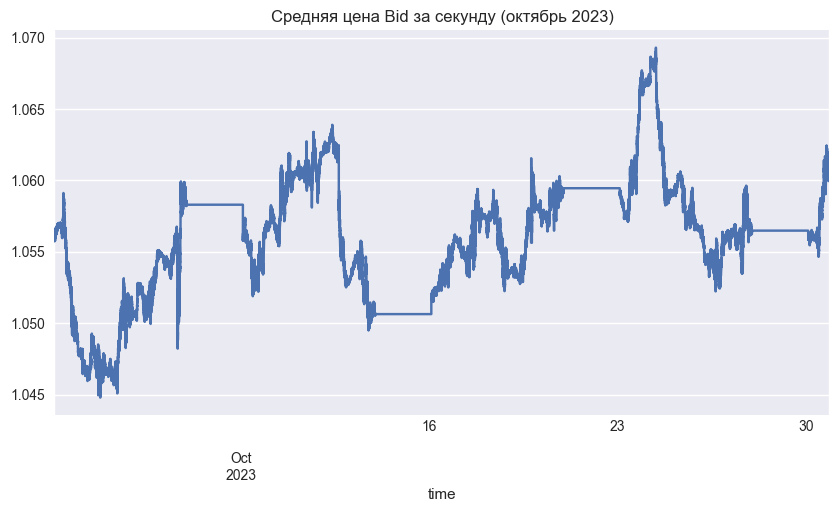

In [13]:
ticks_frame['bid'].plot(figsize=(10,5), grid=True, title='Средняя цена Bid за секунду (октябрь 2023)')

In [ ]:
# сделаем копию данных, что-бы не портить оригинал
ticks_frame_target = ticks_frame.copy()

In [ ]:
# сохраним данные в файл
ticks_frame_target.to_pickle('pkl/ticks_frame_target.pkl')